<a href="https://colab.research.google.com/github/likeshd/time_series_models_libraries/blob/main/LSTM_TS__AttentionMechanism_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to LSTM and Attention Mechanism
The Attention mechanism, initially developed for natural language processing tasks, enhances LSTM by allowing the model to focus on specific parts of the input sequence when making predictions, akin to how human attention works.

## Why Combine LSTM with Attention for Time Series?
The dynamic nature of financial markets makes stock price prediction a challenging task. Traditional LSTMs, despite their ability to capture temporal dependencies, may struggle with the noise and volatility in stock price movements. The Attention mechanism addresses this by providing a weighted importance to different time steps of the input data, allowing the model to prioritize more relevant information and improve its predictive performance.

## Case Study: Predicting AAPL Stock Prices
For our experiment, we utilized four years of AAPL’s historical stock prices, using the ‘Close’ price for our predictions. The data was first normalized to aid the training process and then fed into our LSTM with Attention model.

### Model Architecture
Our model comprises an LSTM layer followed by an Attention layer and a fully connected layer to produce the output. The Attention layer calculates the attention weights and applies them to the LSTM’s outputs, producing a context vector that serves as the input for the final prediction.

In [2]:
# Import necessary libraries
import yfinance as yf
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [10]:
# Download Apple Inc. stock data
apl_data = yf.download('AAPL', start = '2020-01-01', end = '2024-04-01')
apl_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200
...,...,...,...,...,...,...
2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54288300
2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007,57388400


In [13]:
# Use the 'Close' price for prediction
close_prices = apl_data['Close'].values
close_prices

array([ 75.08750153,  74.35749817,  74.94999695, ..., 169.71000671,
       173.30999756, 171.47999573])

In [20]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
close_priced_scaled = scaler.fit_transform(close_prices.reshape(-1,1))
close_priced_scaled

array([[0.13375114],
       [0.1286109 ],
       [0.13278292],
       ...,
       [0.80002469],
       [0.82537361],
       [0.81248787]])

In [21]:
# Prepare the dataset
X = close_priced_scaled[:-1]
y = close_priced_scaled[1:]
print((X))
print((y))

[[0.13375114]
 [0.1286109 ]
 [0.13278292]
 ...
 [0.80805187]
 [0.80002469]
 [0.82537361]]
[[0.1286109 ]
 [0.13278292]
 [0.13030088]
 ...
 [0.80002469]
 [0.82537361]
 [0.81248787]]


In [24]:
# Reshape for LSTM
X = X.reshape(-1, 1, 1)
y = y.reshape(-1, 1)
print(X)
print(y)

[[[0.13375114]]

 [[0.1286109 ]]

 [[0.13278292]]

 ...

 [[0.80805187]]

 [[0.80002469]]

 [[0.82537361]]]
[[0.1286109 ]
 [0.13278292]
 [0.13030088]
 ...
 [0.80002469]
 [0.82537361]
 [0.81248787]]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor( y_train, dtype = torch.float32)
X_test_tensor = torch.tensor( X_test, dtype = torch.float32)
y_test_tensor = torch.tensor( y_test, dtype = torch.float32)



In [35]:


# LSTM with Attention Mechanism
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim = 1, num_layers =1):
      super(LSTMAttention,self).__init__()
      self.hidden_dim = hidden_dim
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
      self.attention = nn.Linear(hidden_dim,1)
      self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      lstm_out, _ = self.lstm(x)
      attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim = -1)
      context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim =1)
      out = self.fc(context_vector)
      return out

In [36]:
# Instantiate and train the model
model = LSTMAttention(input_dim =1, hidden_dim = 50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)


In [39]:
# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')

Epoch 0, Loss: 0.00039684909279458225, Test Loss: 0.0005071588093414903
Epoch 10, Loss: 0.0003948983212467283, Test Loss: 0.0005049039027653635
Epoch 20, Loss: 0.0003929329395759851, Test Loss: 0.0005026441649533808
Epoch 30, Loss: 0.00039096910040825605, Test Loss: 0.0005003404803574085
Epoch 40, Loss: 0.0003890058724209666, Test Loss: 0.0004980082157999277
Epoch 50, Loss: 0.00038704436155967414, Test Loss: 0.0004956742632202804
Epoch 60, Loss: 0.00038508811849169433, Test Loss: 0.0004933521850034595
Epoch 70, Loss: 0.0003831397625617683, Test Loss: 0.0004910437855869532
Epoch 80, Loss: 0.0003812018840108067, Test Loss: 0.0004887495888397098
Epoch 90, Loss: 0.00037927698576822877, Test Loss: 0.0004864699440076947


In [40]:
# Predictions
model.eval()
predictions = model(X_test_tensor).detach().numpy()
predictions_actual = scaler.inverse_transform(predictions)


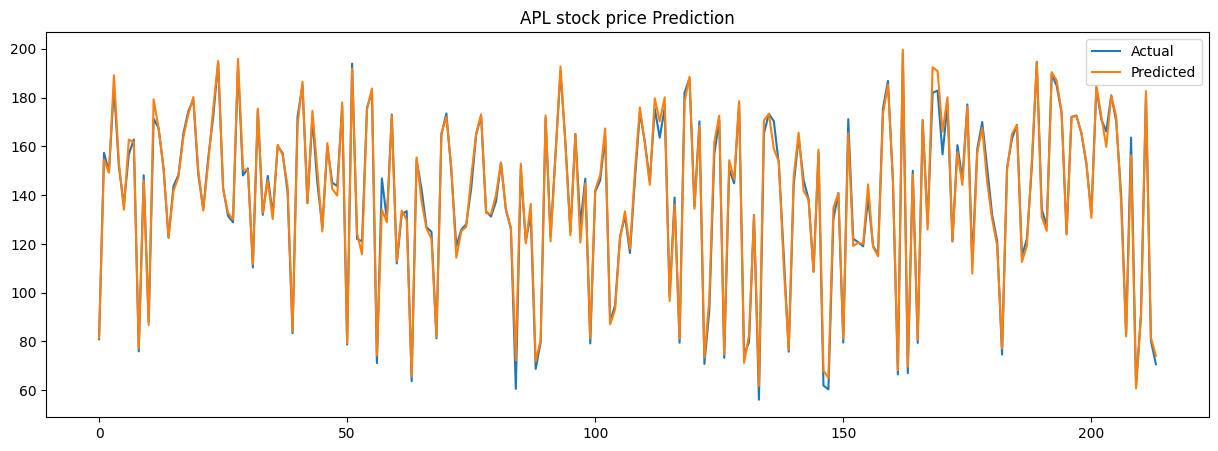

In [41]:
# Plotting
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(y_test), label = 'Actual')
plt.plot(predictions_actual, label = 'Predicted')
plt.title('APL stock price Prediction')
plt.legend()
plt.show()


In [43]:
# Calculate MSE
mse = mean_squared_error(scaler.inverse_transform(y_test), predictions_actual)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 9.770527205991582


### Validation

In [44]:
# Step 1: Fetch additional data for the next month
additional_data = yf.download('AAPL', start='2024-04-02', end='2024-04-15')
additional_data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-02,169.080002,169.339996,168.229996,168.839996,168.839996,49329500
2024-04-03,168.789993,170.679993,168.580002,169.649994,169.649994,47691700
2024-04-04,170.289993,171.919998,168.820007,168.820007,168.820007,53704400
2024-04-05,169.589996,170.389999,168.949997,169.580002,169.580002,42055200
2024-04-08,169.029999,169.199997,168.240005,168.449997,168.449997,37425500
2024-04-09,168.699997,170.080002,168.350006,169.669998,169.669998,42451200
2024-04-10,168.800003,169.089996,167.110001,167.779999,167.779999,49709300
2024-04-11,168.339996,175.460007,168.160004,175.039993,175.039993,91070300
2024-04-12,174.259995,178.360001,174.210007,176.550003,176.550003,101593300


In [45]:
# Step 2: Preprocess the new data
new_close_prices = additional_data['Close'].values
new_close_prices_scaled = scaler.transform(new_close_prices.reshape(-1, 1))

In [46]:
# Preparing the new dataset for prediction
X_new = new_close_prices_scaled[:-1]
y_new_actual = new_close_prices_scaled[1:]

In [47]:
X_new = X_new.reshape(-1, 1, 1)
y_new_actual = y_new_actual.reshape(-1, 1)


In [48]:
# Convert to PyTorch tensors
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)
y_new_actual_tensor = torch.tensor(y_new_actual, dtype=torch.float32)

In [49]:
# Step 3: Make predictions
model.eval()
new_predictions = model(X_new_tensor).detach().numpy()
new_predictions_actual = scaler.inverse_transform(new_predictions)

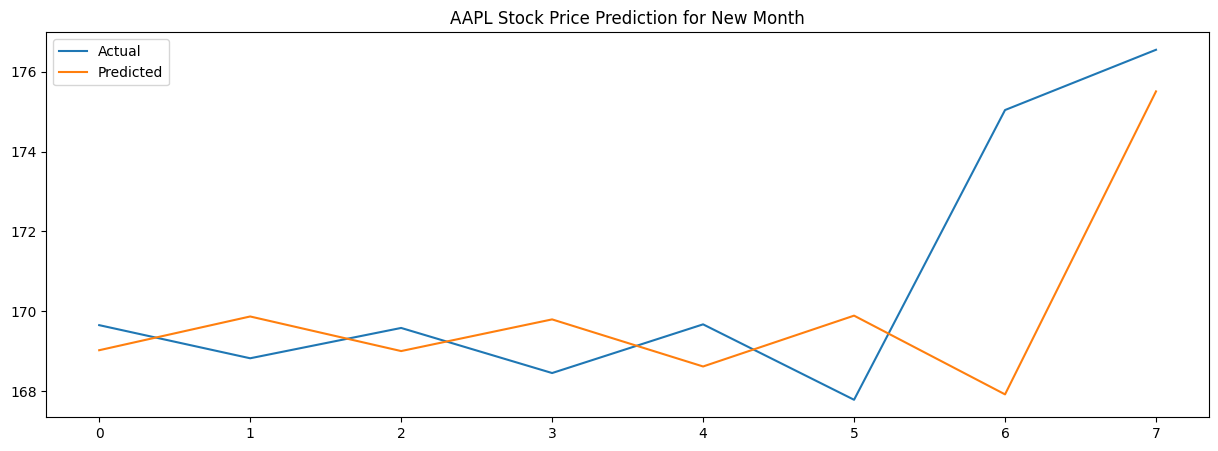

In [50]:
# Step 4: Evaluate the Model
plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(y_new_actual), label='Actual')
plt.plot(new_predictions_actual, label='Predicted')
plt.title('AAPL Stock Price Prediction for New Month')
plt.legend()
plt.show()

In [51]:
# Calculate metrics
new_mse = mean_squared_error(scaler.inverse_transform(y_new_actual), new_predictions_actual)
print(f'New Mean Squared Error: {new_mse}')

New Mean Squared Error: 7.630022513971198


## Conclusion
The LSTM combined with an Attention mechanism has proven to be a powerful architecture for handling time series data like stock prices. It not only captures the temporal patterns but also discerns the pivotal moments that significantly impact future values. While this model represents a substantial step forward, the volatility of financial markets ensures that the search for even more refined models continues. However, the results from our AAPL stock price prediction case study are promising and establish a strong foundation for future explorations.